Monte carlo second class

obstacle
generique
agent en vert
dynamique de chacun , obstacle et les buts
faites des sauvegardes da l agent 
vous testez sur l ensemble des episodes , combien on a gagne
taux de reussite 
deterministe
2eme partie
meme position d obstacle mais la position de goal va changer a chaque episode

I fisrt have to start with generating the grid world
a random function to put the obstacles and two goals
and finally an agent 
and then run montecarlo
so that's it
 

Libraries Section

In [18]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import seaborn as sns
from gym import spaces
import time
from IPython.display import clear_output

Generating the environment

In [75]:


def create_gridworld(size=5, start=(0,0)):
    """Create a GridWorld environment with two distinct goals and one obstacle."""
    
    # Generate two distinct goal positions
    goal1 = (random.randint(0, size-1), random.randint(0, size-1))
    while True:
        goal2 = (random.randint(0, size-1), random.randint(0, size-1))
        if goal2 != goal1:
            break

    # Generate obstacle that doesn't collide with start or goals
    while True:
        obstacle = (random.randint(0, size-1), random.randint(0, size-1))
        if obstacle not in [goal1, goal2, start]:
            break
    
    env = {
        "size": size,
        "start": np.array(start, dtype=int),
        "goal1": np.array(goal1, dtype=int),
        "goal2": np.array(goal2, dtype=int),
        "agent_pos": np.array(start, dtype=int),
        "obstacle": np.array(obstacle, dtype=int),
        "observation_space": spaces.MultiDiscrete([size, size]),
        "action_space": spaces.Discrete(4)
    }
    
    return env

# Example usage
env = create_gridworld()
print(env)


{'size': 5, 'start': array([0, 0]), 'goal1': array([3, 0]), 'goal2': array([4, 1]), 'agent_pos': array([0, 0]), 'obstacle': array([3, 2]), 'observation_space': MultiDiscrete([5 5]), 'action_space': Discrete(4)}


In [60]:
def reset(env):
    """Reset the agent position to the start."""
    env["agent_pos"] = env["start"].copy()
    return env["agent_pos"]

In [59]:
def render_plot(env):
    """Render the grid with agent, two goals, and one obstacle."""
    size = env["size"]
    grid = np.zeros((size, size))

    # Get positions
    r, c = env["agent_pos"]
    g1r, g1c = env["goal1"]
    g2r, g2c = env["goal2"]
    orr, orc = env["obstacle"]

    # Assign values: obstacle=3, goals=2, agent=1
    grid[orr, orc] = 3
    grid[g1r, g1c] = 2
    grid[g2r, g2c] = 2
    grid[r, c] = 1

    # Plot
    plt.imshow(grid, cmap="Pastel1", origin="upper")
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.grid(True, which="both", color="black", linewidth=1)
    plt.title("GridWorld Environment")
    plt.show()

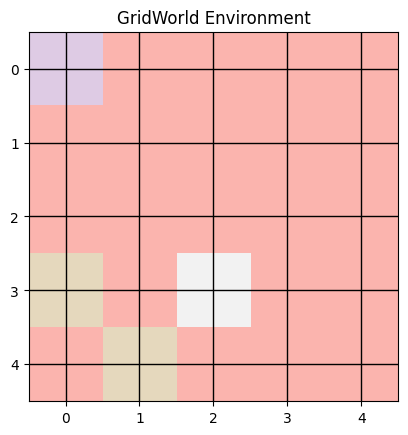

In [76]:
reset(env)
render_plot(env)

In [17]:
import numpy as np

def step(env, action):
    r, c = env["agent_pos"]
    size = env["size"]

    # Proposed new position
    new_r, new_c = r, c
    if action == 0:      # UP
        new_r = max(0, r - 1)
    elif action == 1:    # RIGHT
        new_c = min(size - 1, c + 1)
    elif action == 2:    # DOWN
        new_r = min(size - 1, r + 1)
    elif action == 3:    # LEFT
        new_c = max(0, c - 1)

    proposed_pos = np.array([new_r, new_c])

    # Check obstacle
    if np.array_equal(proposed_pos, env["obstacle"]):
        # Hit the obstacle → stay in place
        reward = -5
        done = False
        new_pos = env["agent_pos"].copy()  # no movement
    # Check goals
    elif np.array_equal(proposed_pos, env["goal1"]) or np.array_equal(proposed_pos, env["goal2"]):
        reward = 10
        done = True
        new_pos = proposed_pos
    else:
        reward = -1
        done = False
        new_pos = proposed_pos

    # Update environment
    env["agent_pos"] = new_pos
    return new_pos, reward, done


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def monte_carlo_train(env, episodes=10000, gamma=0.95, epsilon=0.3, 
                     epsilon_decay=0.995, epsilon_min=0.01, 
                     max_steps=200, live=True, update_freq=10):
    """
    Enhanced Monte Carlo training with:
    - Epsilon decay for better exploration-exploitation balance
    - Max steps per episode to prevent infinite loops
    - Per-action Q-values (not per-state average)
    - Better convergence tracking
    """
    n_actions = env["action_space"].n
    size = env["size"]
    
    # Q-table and returns (separate for each action)
    Q = np.zeros((size, size, n_actions))
    returns = {(s, a): [] for s in [(i, j) for i in range(size) for j in range(size)] 
               for a in range(n_actions)}
    
    rewards_per_episode = []
    steps_per_episode = []
    epsilon_history = []
    success_rate = []
    
    # Setup live plotting
    if live:
        plt.ion()
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
        
        ax1 = fig.add_subplot(gs[0, :])  # Rewards
        ax2 = fig.add_subplot(gs[1, 0])  # Moving average
        ax3 = fig.add_subplot(gs[1, 1])  # Success rate
        ax4 = fig.add_subplot(gs[2, 0])  # Steps per episode
        ax5 = fig.add_subplot(gs[2, 1])  # Epsilon decay
        
        line1, = ax1.plot([], [], 'b-', alpha=0.4, linewidth=1, label='Raw Reward')
        line2, = ax2.plot([], [], 'r-', linewidth=2, label='100-ep MA')
        line3, = ax3.plot([], [], 'g-', linewidth=2, label='Success Rate')
        line4, = ax4.plot([], [], 'purple', linewidth=1.5, label='Steps')
        line5, = ax5.plot([], [], 'orange', linewidth=2, label='Epsilon')
        
        for ax in [ax1, ax2, ax3, ax4, ax5]:
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        ax1.set_ylabel("Total Reward", fontsize=11)
        ax2.set_ylabel("Avg Reward", fontsize=11)
        ax3.set_ylabel("Success Rate (%)", fontsize=11)
        ax4.set_ylabel("Steps", fontsize=11)
        ax5.set_ylabel("Epsilon", fontsize=11)
        
        for ax in [ax4, ax5]:
            ax.set_xlabel("Episode", fontsize=11)
    
    print("🚀 Starting Enhanced Monte Carlo Training...")
    print(f"Episodes: {episodes} | Initial ε: {epsilon} | γ: {gamma}")
    print("-" * 60)
    
    for ep in range(1, episodes + 1):
        # Run one episode
        reset(env)
        episode = []
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            s = tuple(env["agent_pos"])
            
            # ε-greedy policy
            if np.random.rand() < epsilon:
                a = np.random.randint(n_actions)
            else:
                a = np.argmax(Q[s[0], s[1]])
            
            new_state, reward, done = step(env, a)
            episode.append((s, a, reward))
            steps += 1
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_history.append(epsilon)
        
        # Compute returns backward (first-visit MC) - PER ACTION
        G = 0
        visited = set()
        for (s, a, r) in reversed(episode):
            G = gamma * G + r
            if (s, a) not in visited:
                returns[(s, a)].append(G)
                Q[s[0], s[1], a] = np.mean(returns[(s, a)])
                visited.add((s, a))
        
        # Track metrics
        total_reward = sum([r for (_, _, r) in episode])
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
        
        # Track success (reached goal with positive reward)
        success = 1 if done and total_reward > 0 else 0
        if len(success_rate) == 0:
            success_rate.append(success)
        else:
            # Running average of success
            success_rate.append(0.99 * success_rate[-1] + 0.01 * success)
        
        # Live plotting
        if live and ep % update_freq == 0:
            episodes_range = list(range(1, len(rewards_per_episode) + 1))
            
            # Update rewards plot
            line1.set_data(episodes_range, rewards_per_episode)
            ax1.set_xlim(0, max(episodes_range) * 1.05)
            y_min = min(rewards_per_episode)
            y_max = max(rewards_per_episode)
            margin = (y_max - y_min) * 0.1 if y_max != y_min else 1
            ax1.set_ylim(y_min - margin, y_max + margin)
            
            # Moving average
            window = min(100, len(rewards_per_episode))
            if len(rewards_per_episode) >= window:
                moving_avg = np.convolve(rewards_per_episode, 
                                        np.ones(window)/window, 
                                        mode='valid')
                moving_avg_episodes = list(range(window, len(rewards_per_episode) + 1))
                line2.set_data(moving_avg_episodes, moving_avg)
                ax2.set_xlim(window, max(episodes_range) * 1.05)
                ax2.set_ylim(min(moving_avg) * 1.1, max(moving_avg) * 1.1)
            
            # Success rate
            line3.set_data(episodes_range, np.array(success_rate) * 100)
            ax3.set_xlim(0, max(episodes_range) * 1.05)
            ax3.set_ylim(0, 105)
            
            # Steps per episode
            line4.set_data(episodes_range, steps_per_episode)
            ax4.set_xlim(0, max(episodes_range) * 1.05)
            ax4.set_ylim(0, max(max_steps, max(steps_per_episode)) * 1.1)
            
            # Epsilon decay
            line5.set_data(episodes_range, epsilon_history)
            ax5.set_xlim(0, max(episodes_range) * 1.05)
            ax5.set_ylim(0, max(epsilon_history) * 1.1)
            
            # Update main title
            recent_avg = np.mean(rewards_per_episode[-100:]) if len(rewards_per_episode) >= 100 else np.mean(rewards_per_episode)
            recent_success = success_rate[-1] * 100 if success_rate else 0
            ax1.set_title(f"Episode {ep}/{episodes} | Reward: {total_reward:.1f} | " +
                         f"Avg(100): {recent_avg:.1f} | Success: {recent_success:.1f}% | " +
                         f"ε: {epsilon:.3f} | Steps: {steps}",
                         fontsize=12, fontweight='bold')
            
            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)
        
        # Progress update
        if ep % 500 == 0:
            recent_avg = np.mean(rewards_per_episode[-100:])
            recent_success = success_rate[-1] * 100 if success_rate else 0
            avg_steps = np.mean(steps_per_episode[-100:])
            print(f"Ep {ep:5d} | Avg Reward: {recent_avg:6.2f} | " +
                  f"Success: {recent_success:5.1f}% | " +
                  f"Avg Steps: {avg_steps:5.1f} | ε: {epsilon:.4f}")
    
    if live:
        plt.ioff()
        plt.show()
    
    # Final statistics
    print("\n" + "=" * 60)
    print("🎉 Training Completed!")
    print("=" * 60)
    final_avg = np.mean(rewards_per_episode[-100:])
    final_success = success_rate[-1] * 100 if success_rate else 0
    final_steps = np.mean(steps_per_episode[-100:])
    print(f"Final Average Reward (last 100): {final_avg:.2f}")
    print(f"Final Success Rate: {final_success:.1f}%")
    print(f"Average Steps (last 100): {final_steps:.1f}")
    print(f"Total Episodes: {ep}")
    print(f"Final Epsilon: {epsilon:.4f}")
    
    return Q, {
        'rewards': rewards_per_episode,
        'steps': steps_per_episode,
        'success_rate': success_rate,
        'epsilon': epsilon_history
    }


def plot_training_results(results, window=100):
    """Enhanced post-training visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    rewards = results['rewards']
    steps = results['steps']
    success = results['success_rate']
    epsilon = results['epsilon']
    
    episodes = list(range(1, len(rewards) + 1))
    
    # Rewards with moving average
    axes[0, 0].plot(episodes, rewards, alpha=0.3, color='blue', linewidth=0.5)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window, len(rewards) + 1), moving_avg, 
                       color='red', linewidth=2, label=f'{window}-MA')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Training Rewards', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Success rate
    axes[0, 1].plot(episodes, np.array(success) * 100, color='green', linewidth=2)
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Success Rate (%)')
    axes[0, 1].set_title('Success Rate Over Time', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 105)
    
    # Steps per episode
    axes[1, 0].plot(episodes, steps, color='purple', alpha=0.5, linewidth=0.5)
    if len(steps) >= window:
        steps_ma = np.convolve(steps, np.ones(window)/window, mode='valid')
        axes[1, 0].plot(range(window, len(steps) + 1), steps_ma, 
                       color='darkviolet', linewidth=2, label=f'{window}-MA')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Steps')
    axes[1, 0].set_title('Steps per Episode', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Epsilon decay
    axes[1, 1].plot(episodes, epsilon, color='orange', linewidth=2)
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Epsilon')
    axes[1, 1].set_title('Exploration Rate (ε) Decay', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def visualize_policy(env, Q):
    """Visualize the learned policy as arrows."""
    size = env["size"]
    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    print("\n" + "=" * (size * 4))
    print("LEARNED POLICY (Best Action per Cell)")
    print("=" * (size * 4))
    
    for r in range(size):
        row = ""
        for c in range(size):
            if np.array_equal([r, c], env["goal1"]) or np.array_equal([r, c], env["goal2"]):
                row += " 🎯 "
            elif np.array_equal([r, c], env["obstacle"]):
                row += " ⬛ "
            else:
                best_action = np.argmax(Q[r, c])
                q_max = Q[r, c, best_action]
                # Show arrow only if Q-value is non-zero
                if q_max != 0:
                    row += f" {arrows[best_action]} "
                else:
                    row += " ? "
        print(row)
    print("=" * (size * 4))

🚀 Starting Enhanced Monte Carlo Training...
Episodes: 10000 | Initial ε: 0.3 | γ: 0.95
------------------------------------------------------------


C:\Users\ABOUY\AppData\Local\Temp\ipykernel_10996\4193810146.py:131: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(min(moving_avg) * 1.1, max(moving_avg) * 1.1)


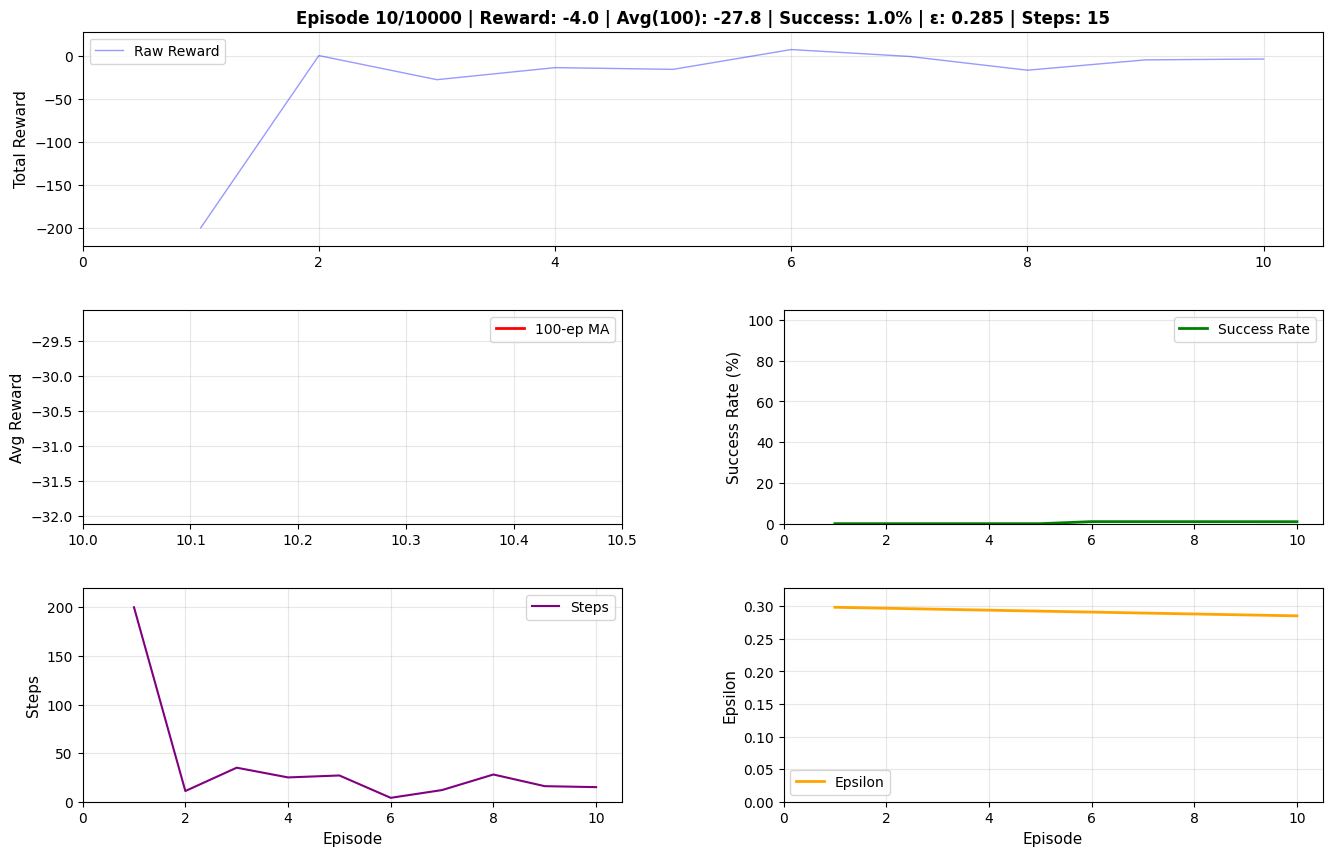

Ep   500 | Avg Reward:   7.96 | Success:  99.1% | Avg Steps:   3.0 | ε: 0.0245
Ep  1000 | Avg Reward:   8.00 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  1500 | Avg Reward:   7.98 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  2000 | Avg Reward:   7.97 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  2500 | Avg Reward:   7.96 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  3000 | Avg Reward:   7.98 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  3500 | Avg Reward:   7.98 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  4000 | Avg Reward:   8.00 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  4500 | Avg Reward:   7.93 | Success: 100.0% | Avg Steps:   3.1 | ε: 0.0100
Ep  5000 | Avg Reward:   7.99 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  5500 | Avg Reward:   7.96 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  6000 | Avg Reward:   8.00 | Success: 100.0% | Avg Steps:   3.0 | ε: 0.0100
Ep  6500 | Avg Reward:   7.98 | Success: 100.0% | Av

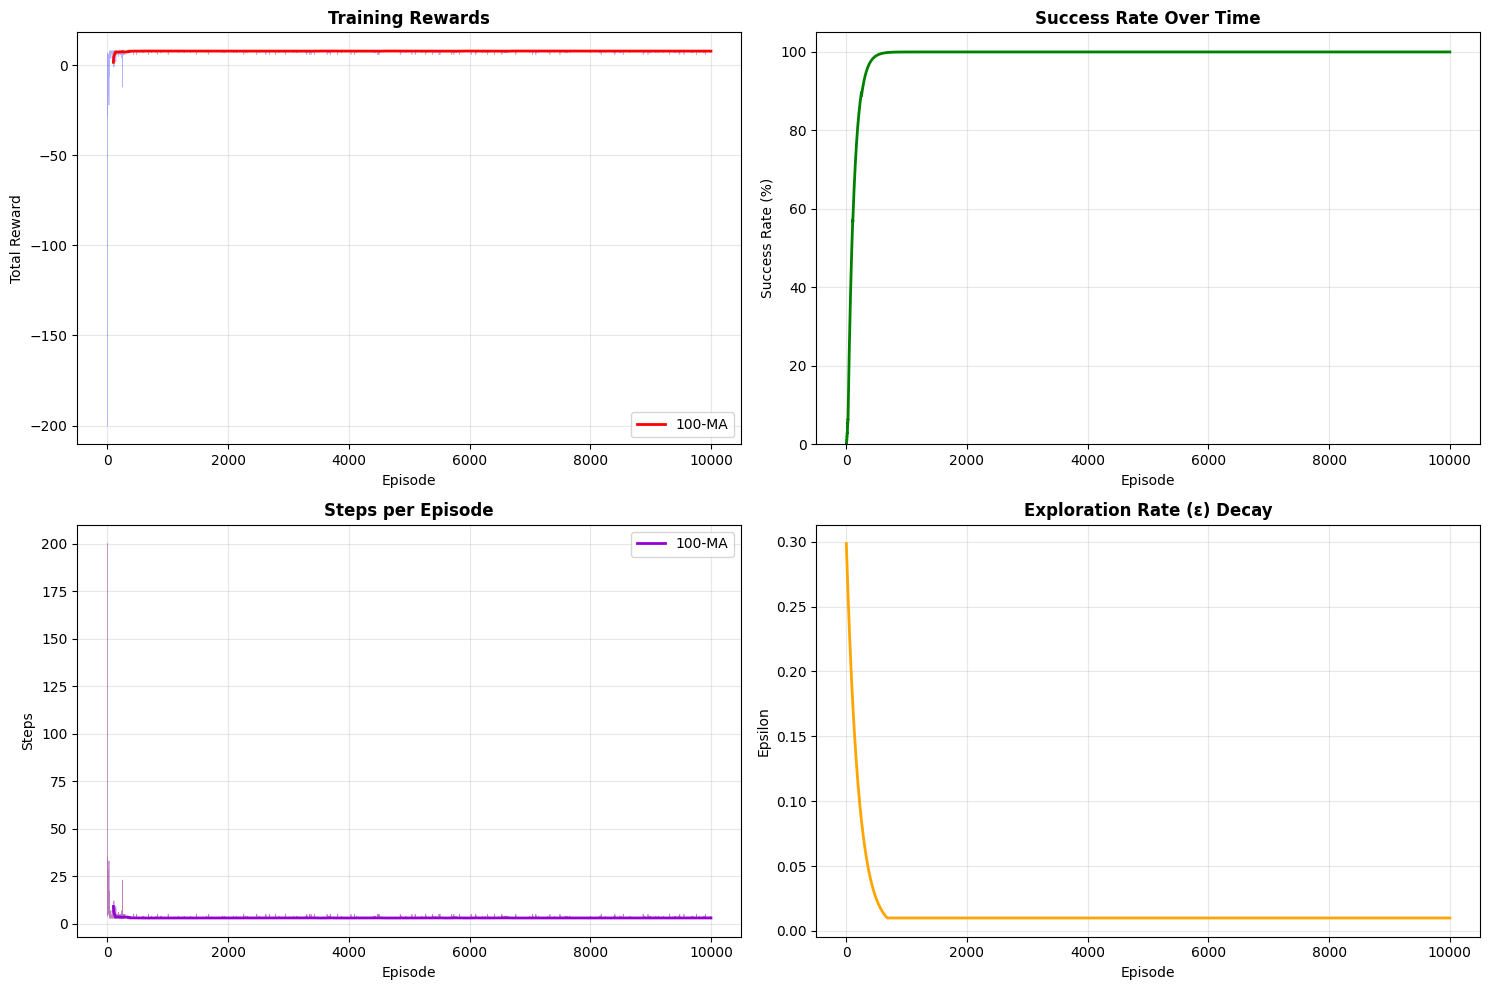

In [64]:
# Train with enhanced settings
env = create_gridworld(size=5)
Q, results = monte_carlo_train(
    env, 
    episodes=10000,          # More episodes for better learning
    gamma=0.95,              # Higher discount factor
    epsilon=0.3,             # Start with more exploration
    epsilon_decay=0.995,     # Gradual decay
    epsilon_min=0.01,        # Keep some exploration
    max_steps=200,           # Prevent infinite loops
    live=True,
    update_freq=10           # Update plot every 10 episodes
)

# Visualize the learned policy
visualize_policy(env, Q)

# Plot comprehensive results
plot_training_results(results)

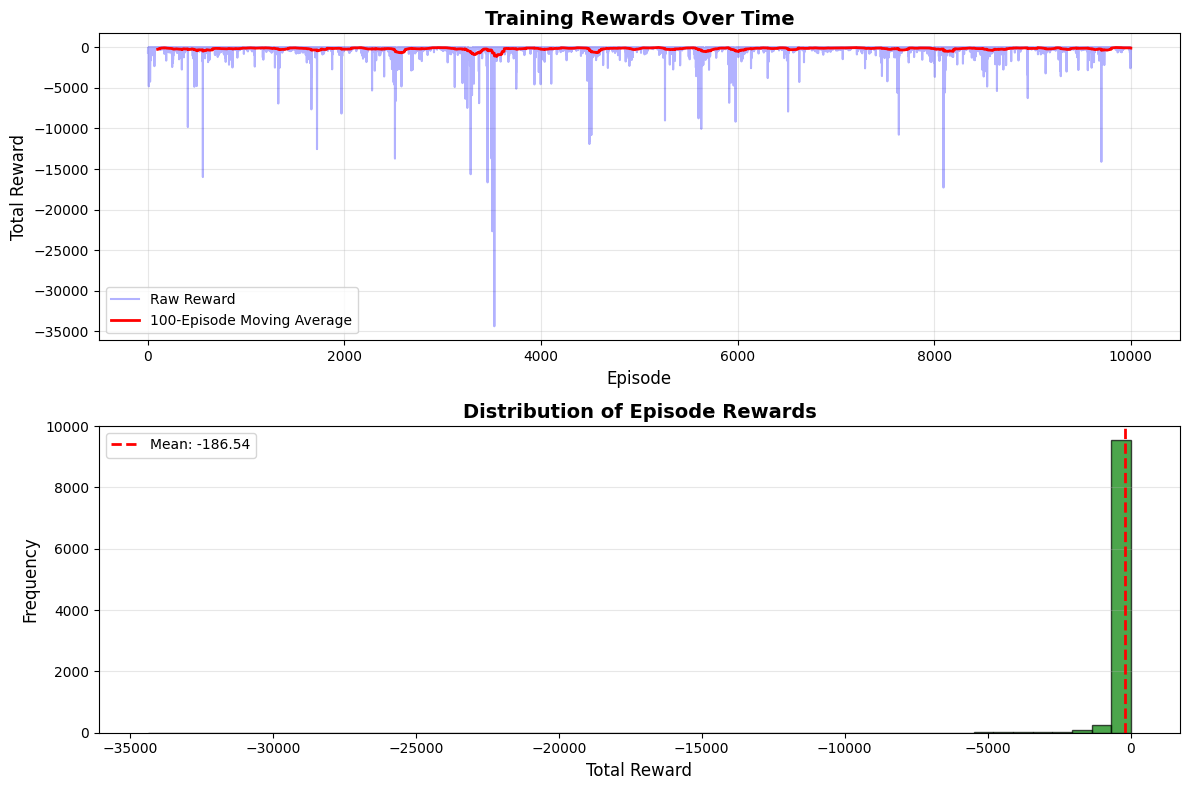


Training Statistics:
Total Episodes: 10000
Mean Reward: -186.54
Std Reward: 807.24
Min Reward: -34369.00
Max Reward: 7.00
Final 100 Episodes Avg: -96.44


In [ ]:
plot_training_results(rewards)

In [51]:
def test_trained_agent(env, Q, num_tests=5, max_steps=50, visualize=True, delay=1):
    """
    Test the trained agent on multiple episodes.
    
    Args:
        env: The gridworld environment
        Q: Trained Q-table
        num_tests: Number of test episodes
        max_steps: Maximum steps per episode
        visualize: Whether to show grid visualization
        delay: Delay between steps (seconds)
    """
    print("\n" + "="*60)
    print("🧪 TESTING TRAINED AGENT")
    print("="*60)
    
    test_results = []
    
    for test_ep in range(1, num_tests + 1):
        print(f"\n--- Test Episode {test_ep}/{num_tests} ---")
        reset(env)
        
        if visualize:
            render_plot(env)
            time.sleep(delay)
        
        total_reward = 0
        steps = 0
        done = False
        path = [tuple(env["agent_pos"])]
        
        while not done and steps < max_steps:
            s = tuple(env["agent_pos"])
            
            # Use greedy policy (no exploration)
            action = np.argmax(Q[s[0], s[1]])
            q_values = Q[s[0], s[1]]
            
            # Take action
            new_state, reward, done = step(env, action)
            total_reward += reward
            steps += 1
            path.append(tuple(env["agent_pos"]))
            
            # Print step info
            actions_names = ['UP', 'RIGHT', 'DOWN', 'LEFT']
            print(f"Step {steps}: Pos={s} → Action={actions_names[action]} → " +
                  f"New Pos={tuple(env['agent_pos'])} → Reward={reward:.1f}")
            
            if visualize:
                clear_output(wait=True)
                render_plot(env)
                time.sleep(delay)
            
            if done:
                if reward > 0:
                    print(f"✅ SUCCESS! Reached goal in {steps} steps with reward {total_reward:.1f}")
                else:
                    print(f"❌ Episode ended (reward: {total_reward:.1f})")
                break
            
            # Check if stuck in loop
            if len(path) > 4 and path[-1] == path[-3] == path[-5]:
                print(f"⚠️ Agent stuck in loop! Stopping...")
                break
        
        if not done:
            print(f"⏱️ Max steps reached ({steps}). Total reward: {total_reward:.1f}")
        
        test_results.append({
            'episode': test_ep,
            'steps': steps,
            'reward': total_reward,
            'success': done and reward > 0,
            'path': path
        })
    
    # Summary statistics
    print("\n" + "="*60)
    print("📊 TEST SUMMARY")
    print("="*60)
    successes = sum([r['success'] for r in test_results])
    avg_steps = np.mean([r['steps'] for r in test_results])
    avg_reward = np.mean([r['reward'] for r in test_results])
    
    print(f"Success Rate: {successes}/{num_tests} ({successes/num_tests*100:.1f}%)")
    print(f"Average Steps: {avg_steps:.1f}")
    print(f"Average Reward: {avg_reward:.1f}")
    print(f"Best Reward: {max([r['reward'] for r in test_results]):.1f}")
    print(f"Worst Reward: {min([r['reward'] for r in test_results]):.1f}")
    
    return test_results


def quick_test(env, Q, max_steps=50):
    """Quick test without visualization - just print results."""
    print("\n🔍 Quick Test (no visualization)")
    reset(env)
    
    total_reward = 0
    steps = 0
    done = False
    actions_names = ['UP↑', 'RIGHT→', 'DOWN↓', 'LEFT←']
    
    print(f"Start: {tuple(env['agent_pos'])}")
    
    while not done and steps < max_steps:
        s = tuple(env["agent_pos"])
        action = np.argmax(Q[s[0], s[1]])
        new_state, reward, done = step(env, action)
        
        total_reward += reward
        steps += 1
        
        print(f"{steps}. {actions_names[action]} → {tuple(env['agent_pos'])} (r={reward:.0f})")
    
    print(f"\n{'✅ SUCCESS' if done and reward > 0 else '❌ FAILED'}: " +
          f"{steps} steps, Total reward: {total_reward:.1f}")
    
    return done and reward > 0


def analyze_q_table(env, Q):
    """Analyze the Q-table to understand what the agent learned."""
    size = env["size"]
    
    print("\n" + "="*60)
    print("📈 Q-TABLE ANALYSIS")
    print("="*60)
    
    # Check how many states have been visited
    visited_states = 0
    unvisited_states = []
    max_q_values = []
    
    for r in range(size):
        for c in range(size):
            max_q = np.max(Q[r, c])
            if max_q != 0:
                visited_states += 1
                max_q_values.append(max_q)
            else:
                unvisited_states.append((r, c))
    
    print(f"Visited States: {visited_states}/{size*size} ({visited_states/(size*size)*100:.1f}%)")
    
    if unvisited_states:
        print(f"Unvisited States: {unvisited_states}")
    
    if max_q_values:
        print(f"Average Max Q-value: {np.mean(max_q_values):.2f}")
        print(f"Highest Q-value: {np.max(max_q_values):.2f}")
        print(f"Lowest Q-value: {np.min(max_q_values):.2f}")
    
    # Show Q-values for start position
    print(f"\nQ-values at START {tuple(env['start'])}:")
    s = tuple(env['start'])
    actions = ['UP↑', 'RIGHT→', 'DOWN↓', 'LEFT←']
    for a, name in enumerate(actions):
        print(f"  {name}: {Q[s[0], s[1], a]:.3f}")

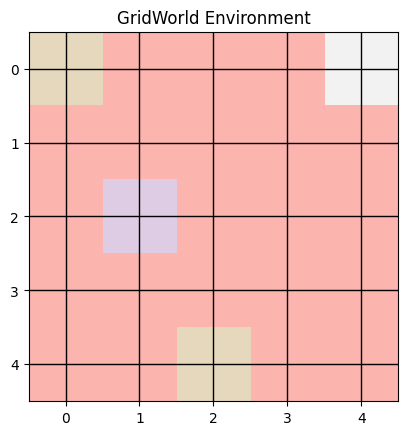

⚠️ Agent stuck in loop! Stopping...
⏱️ Max steps reached (7). Total reward: -7.0

📊 TEST SUMMARY
Success Rate: 0/5 (0.0%)
Average Steps: 7.0
Average Reward: -7.0
Best Reward: -7.0
Worst Reward: -7.0


In [70]:
# Method 1: Full test with visualization
test_results = test_trained_agent(env, Q, num_tests=5, visualize=True, delay=0.5)




🔍 Quick Test (no visualization)
Start: (np.int64(0), np.int64(0))
1. RIGHT→ → (np.int64(0), np.int64(1)) (r=-1)
2. RIGHT→ → (np.int64(0), np.int64(2)) (r=-1)
3. DOWN↓ → (np.int64(1), np.int64(2)) (r=10)

✅ SUCCESS: 3 steps, Total reward: 8.0


True